In [1]:
!git clone https://github.com/anupamhap/mb.git

fatal: destination path 'mb' already exists and is not an empty directory.


In [2]:
!pwd

/content


In [0]:
import os
os.chdir("mb/Tree_Root_Detection")

In [4]:
!ls

classifiers		       Selection_109.jpg
data			       Selection_110.jpg
Hello,_Colaboratory (1).ipynb  Selection_111.jpg
Hello,_Colaboratory (2).ipynb  Selection_112.jpg
helper.py		       Selection_113.jpg
kerasmodel.h5		       test_image2.png
kerasmodel.json		       test_images
__pycache__		       tree_root_intrusion_detection.ipynb
Selection_107.jpg	       videos
Selection_108.jpg


In [0]:
import csv
import matplotlib.image as mpimg
import cv2
import numpy as np
import os
import logging
import glob

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
import sklearn

In [0]:
width = 58
height = 58

images = []

In [68]:
roots   = glob.glob('data/tree/*.JPG')
non_roots   = glob.glob('data/non_tree/*.JPG')
non_roots   += glob.glob('data/non_tree/*.jpg')
print(len(roots), len(non_roots))

51 52


In [0]:
img_size=64
def show3img(img, img1, img2):
   plt.figure(figsize=(6, 2))
   plt.subplot(1, 3, 1)
   plt.imshow(img)
   plt.title("Raw image")
   plt.subplot(1, 3, 2)
   plt.imshow(img1)
   plt.title("Processed image")
   plt.subplot(1, 3, 3)
   plt.imshow(img2)
   plt.title("Augmented image")
   plt.show()
   
def eq_Hist(img):
   #Histogram Equalization
   img2=img.copy()
   img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
   img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
   img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
   return img2

def scale_img(img):
   img2=img.copy()
   sc_y=0.4*np.random.rand()+1.0
   img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
   c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
   return img2

def crop(img, mar=0):
   c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
   return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

def rotate_img(img):
   c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
   ang = 30.0*np.random.rand()-15
   Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
   return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
   gb = cv2.GaussianBlur(img, (5,5), 20.0)
   return cv2.addWeighted(img, 2, gb, -1, 0)
#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
   img2=cv2.multiply(img, np.array([s]))
   return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
   m=127.0*(1.0-s)
   return lin_img(img, s, m)

def transform_img(img):
   img2=sharpen_img(img)
   img2=crop(img2,3)
   img2=contr_img(img2, 1.5)
   return eq_Hist(img2)

def augment_img(img):
   img=contr_img(img, 1.8*np.random.rand()+0.2)
   img=rotate_img(img)
   img=scale_img(img)
   return transform_img(img)


In [71]:
X_train_aug_roots = []
y_train_aug = []

def create_data(n=10):
   for i in range(len(roots)):
       img=mpimg.imread(roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(1)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(1)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(7)

Total number of images in the augmented dataset =  408


In [72]:
def create_data(n=10):
   for i in range(len(non_roots)):
       img=mpimg.imread(non_roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(0)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(0)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(7)

Total number of images in the augmented dataset =  824


In [73]:
print(len(roots))

51


In [74]:
for i in range(len(roots)):
     img=mpimg.imread(roots[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_roots.append(img)
     y_train_aug.append(1)

for i in range(len(non_roots)):
     img=mpimg.imread(non_roots[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_roots.append(img)
     y_train_aug.append(0)
   
print(len(y_train_aug))

927


In [0]:
activation = 'relu'
dropout = 1

def model(dshape):
    
    seq_model = Sequential()

    seq_model.add(BatchNormalization(input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(24, (5, 5), padding='valid',
                  activation=activation, strides=(2, 2)))

    seq_model.add(Conv2D(36, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(48, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Dropout(0.6))
#   seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Flatten())
    seq_model.add(Dropout(0.6))
    seq_model.add(Dense(100, activation=activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(50, activation=activation))
    seq_model.add(Dropout(0.3))
    seq_model.add(Dense(10, activation=activation))
    seq_model.add(Dense(1, activation='sigmoid'))
    seq_model.compile(loss='binary_crossentropy', optimizer=adam(), metrics=['accuracy'])
    seq_model.summary()

    return seq_model

In [0]:
from sklearn.utils import shuffle
from keras.utils.data_utils import Sequence

images, labels = shuffle(X_train_aug_roots, y_train_aug)

In [77]:
images = np.asarray(images)
labels = np.asarray(labels)
print(images.dtype, images.shape)
print(type(images))
print(labels)

uint8 (927, 58, 58, 3)
<class 'numpy.ndarray'>
[1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0
 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1
 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0
 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0
 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 1
 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 0 1
 0 1 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0
 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1
 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0
 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1
 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 0
 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 

In [78]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam
#from keras.utils.data_utils import Sequence

keras_model = model((height, width, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 58, 58, 3)         12        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 36)        21636     
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 36)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 48)          43248     
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 64)          27712     
__________

In [80]:
keras_model.fit(images, labels, epochs=25, batch_size=32, verbose=1, shuffle=True, validation_split=0.2)

Train on 741 samples, validate on 186 samples
Epoch 1/25
741/741 [==============================] - 2s 3ms/step - loss: 0.5527 - acc: 0.7706 - val_loss: 0.5958 - val_acc: 0.7527
Epoch 2/25
741/741 [==============================] - 3s 3ms/step - loss: 0.5404 - acc: 0.7895 - val_loss: 0.6065 - val_acc: 0.7204
Epoch 3/25
741/741 [==============================] - 3s 3ms/step - loss: 0.5200 - acc: 0.7949 - val_loss: 0.5292 - val_acc: 0.8118
Epoch 4/25
741/741 [==============================] - 2s 3ms/step - loss: 0.4958 - acc: 0.7989 - val_loss: 0.5587 - val_acc: 0.7366
Epoch 5/25
741/741 [==============================] - 2s 3ms/step - loss: 0.4807 - acc: 0.8232 - val_loss: 0.4821 - val_acc: 0.8495
Epoch 6/25
741/741 [==============================] - 2s 3ms/step - loss: 0.4996 - acc: 0.7895 - val_loss: 0.5644 - val_acc: 0.7688
Epoch 7/25
741/741 [==============================] - 2s 3ms/step - loss: 0.4602 - acc: 0.8016 - val_loss: 0.5695 - val_acc: 0.7473
Epoch 8/25
192/741 [======>...

741/741 [==============================] - 2s 3ms/step - loss: 0.4761 - acc: 0.7908 - val_loss: 0.5490 - val_acc: 0.7688
Epoch 9/25
741/741 [==============================] - 2s 3ms/step - loss: 0.4527 - acc: 0.8084 - val_loss: 0.5417 - val_acc: 0.7796
Epoch 10/25
741/741 [==============================] - 2s 3ms/step - loss: 0.4621 - acc: 0.8138 - val_loss: 0.5486 - val_acc: 0.7581
Epoch 11/25
741/741 [==============================] - 2s 3ms/step - loss: 0.4434 - acc: 0.8070 - val_loss: 0.5547 - val_acc: 0.7688
Epoch 12/25
741/741 [==============================] - 2s 3ms/step - loss: 0.4062 - acc: 0.8246 - val_loss: 0.5225 - val_acc: 0.7849
Epoch 13/25
741/741 [==============================] - 2s 3ms/step - loss: 0.3771 - acc: 0.8543 - val_loss: 0.5166 - val_acc: 0.7903
Epoch 14/25
741/741 [==============================] - 2s 3ms/step - loss: 0.4062 - acc: 0.8394 - val_loss: 0.5038 - val_acc: 0.7849
Epoch 15/25
608/741 [=======================>......] - ETA: 0s - loss: 0.4336 - ac

741/741 [==============================] - 2s 3ms/step - loss: 0.4163 - acc: 0.8178 - val_loss: 0.5796 - val_acc: 0.7688
Epoch 16/25
741/741 [==============================] - 2s 3ms/step - loss: 0.3799 - acc: 0.8664 - val_loss: 0.5237 - val_acc: 0.7957
Epoch 17/25
741/741 [==============================] - 2s 3ms/step - loss: 0.3456 - acc: 0.8529 - val_loss: 0.5350 - val_acc: 0.7957
Epoch 18/25
741/741 [==============================] - 2s 3ms/step - loss: 0.3353 - acc: 0.8745 - val_loss: 0.4484 - val_acc: 0.8656
Epoch 19/25
741/741 [==============================] - 2s 3ms/step - loss: 0.3432 - acc: 0.8623 - val_loss: 0.6084 - val_acc: 0.7581
Epoch 20/25
741/741 [==============================] - 2s 3ms/step - loss: 0.3529 - acc: 0.8529 - val_loss: 0.4616 - val_acc: 0.8387
Epoch 21/25
741/741 [==============================] - 2s 3ms/step - loss: 0.3120 - acc: 0.8691 - val_loss: 0.3416 - val_acc: 0.9301
Epoch 22/25
608/741 [=======================>......] - ETA: 0s - loss: 0.3325 - a

741/741 [==============================] - 2s 3ms/step - loss: 0.3326 - acc: 0.8745 - val_loss: 0.5043 - val_acc: 0.8226
Epoch 23/25
741/741 [==============================] - 2s 3ms/step - loss: 0.2963 - acc: 0.8947 - val_loss: 0.3589 - val_acc: 0.8817
Epoch 24/25
741/741 [==============================] - 2s 3ms/step - loss: 0.2962 - acc: 0.8866 - val_loss: 0.4519 - val_acc: 0.8065
Epoch 25/25
741/741 [==============================] - 2s 3ms/step - loss: 0.3223 - acc: 0.8853 - val_loss: 0.4653 - val_acc: 0.8333


In [0]:
def  save_keras_model (save_model, path):
    """Save keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

    logging.info('Keras json model saved. %s', path + 'model.json')
    logging.info('Keras h5 model saved. %s', path + 'model.h5')

In [0]:
save_keras_model(keras_model, 'keras')

In [83]:
!ls

classifiers		       Selection_109.jpg
data			       Selection_110.jpg
Hello,_Colaboratory (1).ipynb  Selection_111.jpg
Hello,_Colaboratory (2).ipynb  Selection_112.jpg
helper.py		       Selection_113.jpg
kerasmodel.h5		       test_image2.png
kerasmodel.json		       test_images
__pycache__		       tree_root_intrusion_detection.ipynb
Selection_107.jpg	       videos
Selection_108.jpg


# New Section

In [0]:
from google.colab import files


files.download('kerasmodel.h5')
files.download('kerasmodel.json')


In [0]:
from keras.models import model_from_json
model_path = 'kerasmodel'

inf_model = model_from_json(open(model_path + '.json','r').read())
inf_model.load_weights(model_path + '.h5')

In [0]:
def find_roots(img, ystart, ystop, scale, pix_per_cell,cell_per_block):#, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins):
    
    boxes=[]
  
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = hp.convert_color(img_tosearch, conv=color_space)
    ctrans_tosearch = img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
#     nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    print(nxsteps)
    
#     # Compute individual channel HOG features for the entire image
#     hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
           
#             hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (58,58))
#             plt.imshow(subimg)
#             plt.show
            # Get color features
#             spatial_features = hp.bin_spatial(subimg, size=spatial_size)
#             hist_features = hp.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))  
            test_prediction = round(inf_model.predict(np.expand_dims(subimg, 0))[0, 0])
#             print(test_prediction)
#             test_prediction = svc.predict(test_features)
            
            if test_prediction == 1.0:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))#,(0,0,255),6)) 
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes

In [0]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for box in bboxes:
        cv2.rectangle(draw_img,box[0],box[1],color,thick)
    
    return draw_img # Change this line to return image copy with boxes

test_images/treeroot.JPG
5


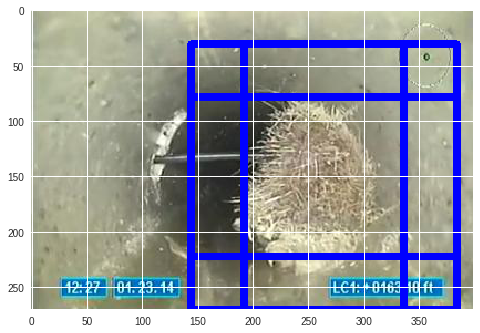

In [116]:
import matplotlib.pyplot as plt
ystart = 30
ystop = 270
scale = 3
pix_per_cell=8
cell_per_block=2
test_images=glob.glob('test_images/*.JPG')

for fname in test_images:
    print(fname)
    test_img=mpimg.imread(fname)
    #plt.subplot(6,1,i)
    boxes=find_roots(test_img, ystart, ystop, scale, pix_per_cell,cell_per_block ) #, clf, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins)
    #print(boxes[0][0])
    test_out_img=draw_boxes(test_img,boxes)
    plt.imshow(
    )
    plt.show()

In [43]:
!ls
print(labels)

classifiers		       Selection_109.jpg
data			       Selection_110.jpg
Hello,_Colaboratory (1).ipynb  Selection_111.jpg
Hello,_Colaboratory (2).ipynb  Selection_112.jpg
helper.py		       Selection_113.jpg
kerasmodel.h5		       test_image2.png
kerasmodel.json		       test_images
__pycache__		       tree_root_intrusion_detection.ipynb
Selection_107.jpg	       videos
Selection_108.jpg
[1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1
 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1
 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1
 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0
 0 0 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1
 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0
 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0
 0 1 1 1 0 0 0 1

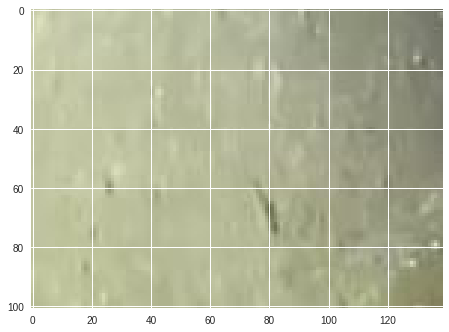

In [102]:
plt.imshow(mpimg.imread( "data/non_tree/1.JPG"))

In [104]:
im = mpimg.imread( "data/non_tree/1.JPG")
im = cv2.resize(im,(58,58))
print( round(inf_model.predict(np.expand_dims(im, 0))[0, 0]))

0.0


In [100]:
!ls

classifiers		       Selection_109.jpg
data			       Selection_110.jpg
Hello,_Colaboratory (1).ipynb  Selection_111.jpg
Hello,_Colaboratory (2).ipynb  Selection_112.jpg
helper.py		       Selection_113.jpg
kerasmodel.h5		       test_image2.png
kerasmodel.json		       test_images
__pycache__		       tree_root_intrusion_detection.ipynb
Selection_107.jpg	       videos
Selection_108.jpg


In [0]:
#print(scales,ystarts)

def process_frame(image):
    boxes=[]
    for i in range(len(scales)):
        boxes.append(find_roots(test_img, ystart, ystop, scale, pix_per_cell,cell_per_block )) #find_roots(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins))
    
    boxes = [item for sublist in boxes for item in sublist] 
#     heatmap_img = np.zeros_like(image[:,:,0])
#     heatmap_img = add_heat(heatmap_img, boxes)
    
#     heat_history.append(heatmap_img)
#     heatmap_img = np.array(heat_history).sum(axis=0)
#     heatmap_img = apply_threshold(heatmap_img,5)
    
#     # # Find final boxes from heatmap using label function
#     labels = label(heatmap_img)
#     draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw_img = draw_boxes(image,boxes)
    
    return draw_img


In [0]:
from moviepy.editor import VideoFileClip

output_location = 'test_output_video/yuv_11_8_debug_full_without_ystart.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_input = VideoFileClip("project_video.mp4")#.subclip(40,43)

video_output = video_input.fl_image(process_frame) #NOTE: this function expects color images!!

#%time undist_clip.write_videofile(undist_output, audio=False)
print("anupam")
video_output.write_videofile(output_location, audio=False)
video_input.reader.close()
video_input.audio.reader.close_proc()
video_output.reader.close()
video_output.audio.reader.close_proc()